## Using Spectral Clustering to Detect Weather Clusters

In [289]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering 
from scipy.spatial import distance

In [290]:
# code from hw3
def kmeans_sklearn(data, k):
    km_alg = KMeans(n_clusters=k)
    fit1 = km_alg.fit(data)
    labels = fit1.labels_
    #centers = fit1.cluster_centers_
    
    return labels #, centers

def spectral_sklearn(data, k):
    sc_alg = SpectralClustering(n_clusters=k)
    fit1 = sc_alg.fit(data)
    labels = fit1.labels_
    
    return labels

# Question 2
def make_adj(array_np):
    pair_dists = distance.cdist(array_np, array_np, 'euclidean')
    
    # adapted from:
    # https://www.geeksforgeeks.org/python-replace-negative-value-with-zero-in-numpy-array/
    pair_dists[pair_dists < 0.5] = 0.3 # placeholder so doesn't get set to 0
    pair_dists[pair_dists >= 0.5] = 0 
    pair_dists[pair_dists > 0] = 1 # undo placeholder
    
    # make sure diagonals are 0
    # from https://numpy.org/doc/stable/reference/generated/numpy.fill_diagonal.html
    np.fill_diagonal(pair_dists, 0)
    
    return pair_dists
    
def my_laplacian(A):
    '''returns unnormalized Laplacian of numpy array/adjacency list'''
    # https://numpy.org/doc/stable/reference/generated/numpy.sum.html
    rowSums = np.sum(A, axis = 1)

    # degree matrix
    # counts num datapoints each datapoint near
    # https://numpy.org/doc/stable/reference/generated/numpy.diag.html
    D = np.diag(rowSums)

    # unnormalized Laplacian
    L = D - A

    return L

# Question 3
def spect_clustering(L, k):
    # eigens of L
    eig_vals, eig_vecs = np.linalg.eig(L)
    # prevent complex numbers
    # https://numpy.org/doc/stable/reference/generated/numpy.real.html
    eig_vals = np.real(eig_vals)
    eig_vecs = np.real(eig_vecs)
    print("eigvals", eig_vals)
    print("eigvecs", eig_vecs)
    
    # sort smallest to greatest eigenvalue
    inds = eig_vals.argsort()
    eig_vals = eig_vals[inds]
    eig_vecs = eig_vecs[:,inds]
    print("eigvec shape", eig_vecs.shape)
    
    # find non-zero eigenvalues only
    # https://numpy.org/doc/stable/reference/generated/numpy.argwhere.html
    # pointed me to np.nonzero()
    nonZinds = np.nonzero(eig_vals)
    eig_vals = eig_vals[nonZinds]
    eig_vecs = eig_vecs[nonZinds]
    
    # first k eigenvectors
    k_eig_vecs = eig_vecs[:, :k]
    
    print("keigvec shape", k_eig_vecs.shape)
    
    return kmeans_sklearn(k_eig_vecs, k)

# code from lab 6
def standardize(data):
    '''Standardize a dataframe'''
    mean_vec = np.mean(data, axis=0)
    sd_vec = np.std(data, axis=0)

    data_std = data.copy()
    for i in range(data.shape[1]): # for every column
        data_std[:,i] = (data[:,i] - mean_vec[i]*np.ones(data.shape[0]))/sd_vec[i]
        
    return data_std

## Using Weather Data for Raleigh, NC

What weather clusters come up when we remove temporal indicators, such as dates and seasons?

In [291]:
# import data
weather_pd = pd.read_csv('../data/weather.csv', index_col = 0)
weather_pd = weather_pd.drop(['STP', 'GUST', 'SNDP'], axis=1) # remove temporal indicators
# 'YEAR', 'MONTH', 'DAY', 'SEASON', 

# drop station pressure bc redundant with sea level and not collected in 2000, 2002, 2004
# and drop max gust because missing for half the days and somewhat redundant w/ mxspd

In [292]:
weather_pd.head()

,YEAR,MONTH,DAY,SEASON,TEMP,DEWP,SLP,VISIB,WDSP,MXSPD,MAX,MIN,PRCP
0,2000,1,1,0,47.6,38.1,1023.7,8.3,3.0,10.1,66.9,33.1,0.00
1,2000,1,2,0,55.3,46.3,1024.2,9.5,4.8,14.0,70.0,33.1,0.00
2,2000,1,3,0,62.6,55.4,1021.3,8.4,8.5,14.0,73.9,43.0,0.00
3,2000,1,4,0,65.2,58.6,1014.4,9.5,15.3,28.0,73.9,55.0,0.00
4,2000,1,5,0,45.7,30.9,1019.8,9.8,6.4,11.1,57.9,37.0,0.34


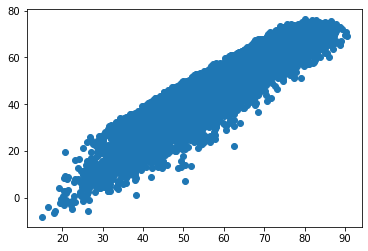

In [293]:
plt.scatter(weather_pd['TEMP'], weather_pd['DEWP'])

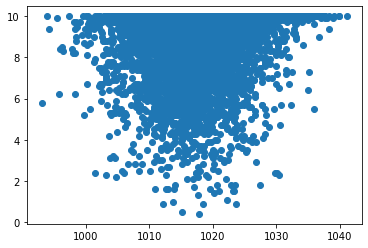

In [294]:
plt.scatter(weather_pd['SLP'], weather_pd['VISIB'])

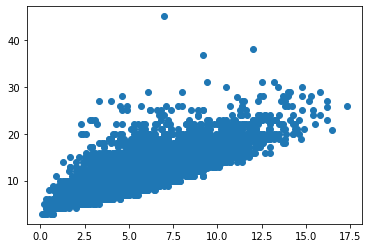

In [295]:
plt.scatter(weather_pd['WDSP'], weather_pd['MXSPD'])

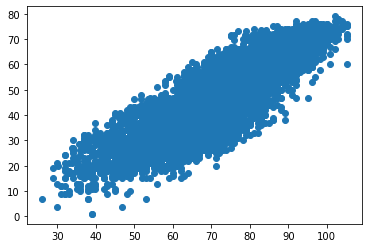

In [296]:
plt.scatter(weather_pd['MAX'], weather_pd['MIN'])

In [297]:
#plt.scatter(weather_pd['PRCP'], weather_pd['SNDP'])

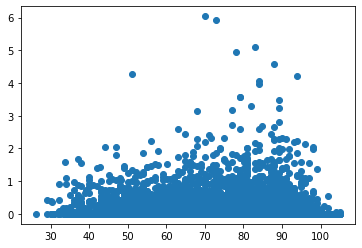

In [298]:
plt.scatter(weather_pd['MAX'], weather_pd['PRCP'])

In [299]:
# convert to numpy
weather = weather_pd.to_numpy()[:, 1:]
weather_std = standardize(weather)
# not forgetting to standardize, sklearn PCA does it automatically

## Take a look in 2D

In [300]:
# use PCA to plot in 2D
pca = PCA(n_components=2)
weather_two = pca.fit_transform(weather_std)

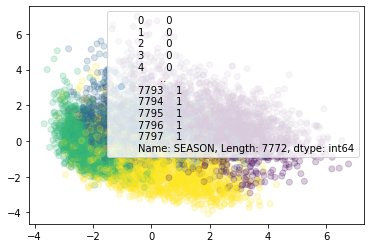

In [301]:
fig, ax = plt.subplots()

ax.scatter(weather_two[:,0], weather_two[:,1], c=weather_pd['SEASON'], label=weather_pd['SEASON'], alpha=0.2)
ax.legend()

In [302]:
weather_two_pd = pd.DataFrame(weather_two, columns=["X", "Y"])
weather_two_pd['SEASON'] = weather_pd['SEASON']
weather_two_pd.head()

,X,Y,SEASON
0,2.205872,0.219957,0.0
1,1.639713,1.046209,0.0
2,0.561612,2.014351,0.0
3,-0.466994,5.580171,0.0
4,2.376241,1.346825,0.0


<AxesSubplot:xlabel='X', ylabel='Y'>

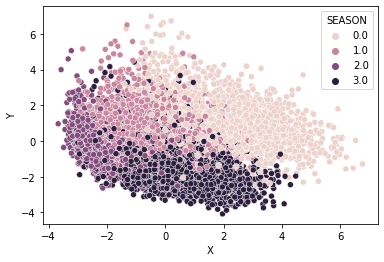

In [303]:
# https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.scatterplot(data=weather_two_pd, x="X", y="Y", hue="SEASON")

In [304]:
weather_two.shape

(7772, 2)

## Take a look in 3D

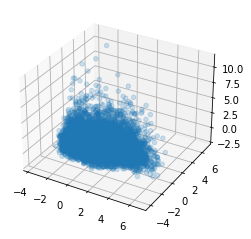

In [305]:
pca = PCA(n_components=3)
weather_two = pca.fit_transform(weather_std)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(weather_two[:,0], weather_two[:,1], weather_two[:,2], alpha=0.2)

## Find Clusters with Spectral Clustering

In [306]:
weather.shape
L.shape

(7772, 7772)

In [307]:
weather

array([[ 1. ,  1. ,  0. , ..., 66.9, 33.1,  0. ],
       [ 1. ,  2. ,  0. , ..., 70. , 33.1,  0. ],
       [ 1. ,  3. ,  0. , ..., 73.9, 43. ,  0. ],
       ...,
       [ 5. ,  5. ,  1. , ..., 87.1, 63. ,  0.2],
       [ 5. ,  6. ,  1. , ..., 84.9, 55. ,  0. ],
       [ 5. ,  7. ,  1. , ..., 57.9, 46.9,  0. ]])

In [308]:
A = make_adj(weather_std)
L = my_laplacian(A)

In [309]:
labels = spect_clustering(L, 2)

eigvals [ 3.00000000e+00  1.00000000e+00 -3.36770206e-17 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
eigvecs [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
eigvec shape (7772, 7772)
keigvec shape (595, 2)


In [310]:
labels.shape

(595,)

ValueError: 'c' argument has 595 elements, which is inconsistent with 'x' and 'y' with size 7772.

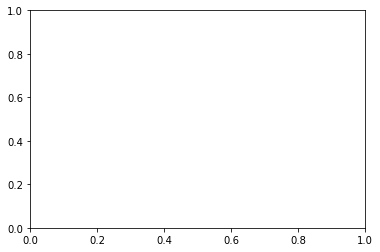

In [311]:
# Plot labeled points
plt.scatter(weather_two[:,0], weather_two[:,1], c=labels, s=50, cmap="spring")
# Add cluster centers
#plt.scatter(centers[:, 0], centers[:, 1], c='black', marker="x", s=200, alpha=0.75)

## sklearn implementations

In [312]:
# K-Means standardized

labels = kmeans_sklearn(weather_std, 4)

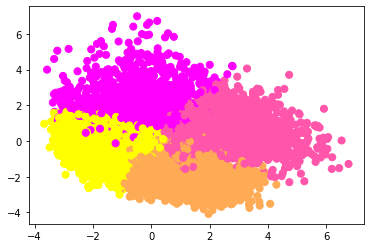

In [313]:
# Plot labeled points
plt.scatter(weather_two[:,0], weather_two[:,1], c=labels, s=50, cmap="spring")

In [314]:
# Spectral Clustering standardized

labels = spectral_sklearn(weather_std, 4)

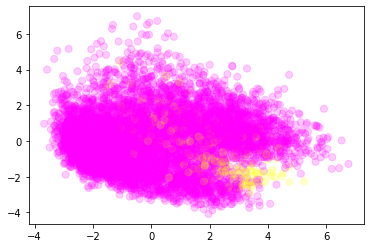

In [315]:
# Plot labeled points
plt.scatter(weather_two[:,0], weather_two[:,1], c=labels, s=50, cmap="spring", alpha = 0.2)